## 6.5 Pytorch实现cifar10多分类
本节以CIFAR-10作为数据集，使用PyTorch利用卷积神经网络进行分类

### 6.5.1 数据集说明
	CIFAR-10数据集由10个类的60000个32x32彩色图像组成，每个类有6000个图像。有50000个训练图像和10000个测试图像。
	数据集分为5个训练批次和1个测试批次，每个批次有10000个图像。测试批次包含来自每个类别的恰好1000个随机选择的图像。训练批次以随机顺序选取剩余图像，但一些训练批次可能更多会选取来自一个类别的图像。总体来说，五个训练集之和包含来自每个类的正好5000张图像。
	图6-27 显示了数据集中涉及的10个类，以及来自每个类的10个随机图像。
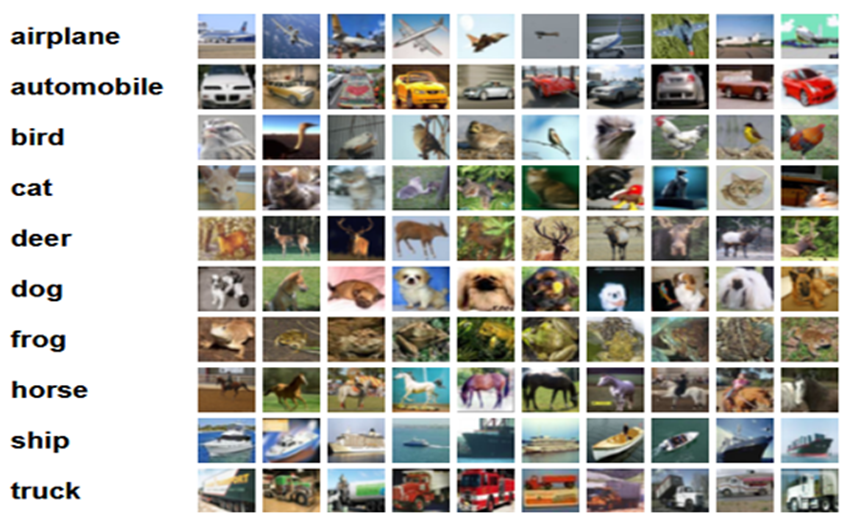
<center>图6-27 CIFAR-10数据集</center>
	这10类都是彼此独立的，不会出现重叠，即这是多分类单标签问题。

### 6.5.2 加载数据
	这里采用PyTorch提供的数据集加载工具torchvision，同时对数据进行预处理。为方便起见，我们已预先下载好数据并解压，存放在当前目录的data目录下，所以，参数download=False。

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

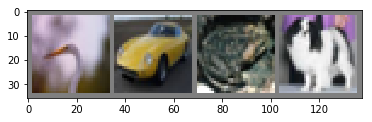

 bird   car  frog   dog


In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 6.5.3 构建网络
根据图6-1 构建网络
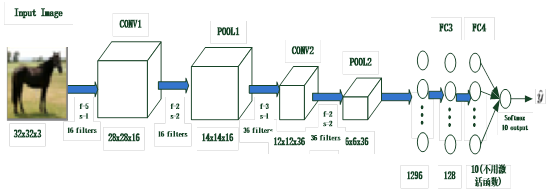
<center>图6-1 卷积神经网络架构示意图</center>

In [8]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)      

    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

net = CNNNet()
net=net.to(device)

In [9]:
print("net have {} paramerters in total".format(sum(x.numel() for x in net.parameters())))

net have 173742 paramerters in total


In [10]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=LR)


In [11]:
print(net)

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
#取模型中的前四层
nn.Sequential(*list(net.children())[:4])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### 6.5.4 训练模型

In [13]:
for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.116
[1,  4000] loss: 1.873
[1,  6000] loss: 1.742
[1,  8000] loss: 1.684
[1, 10000] loss: 1.616
[1, 12000] loss: 1.498
[2,  2000] loss: 1.358
[2,  4000] loss: 1.227
[2,  6000] loss: 1.186
[2,  8000] loss: 1.183
[2, 10000] loss: 1.137
[2, 12000] loss: 1.094
[3,  2000] loss: 0.997
[3,  4000] loss: 0.997
[3,  6000] loss: 0.965
[3,  8000] loss: 0.970
[3, 10000] loss: 0.940
[3, 12000] loss: 0.940
[4,  2000] loss: 0.817
[4,  4000] loss: 0.837
[4,  6000] loss: 0.827
[4,  8000] loss: 0.854
[4, 10000] loss: 0.828
[4, 12000] loss: 0.834
[5,  2000] loss: 0.690
[5,  4000] loss: 0.707
[5,  6000] loss: 0.725
[5,  8000] loss: 0.740
[5, 10000] loss: 0.747
[5, 12000] loss: 0.748
[6,  2000] loss: 0.590
[6,  4000] loss: 0.607
[6,  6000] loss: 0.629
[6,  8000] loss: 0.651
[6, 10000] loss: 0.679
[6, 12000] loss: 0.678
[7,  2000] loss: 0.498
[7,  4000] loss: 0.549
[7,  6000] loss: 0.573
[7,  8000] loss: 0.580
[7, 10000] loss: 0.590
[7, 12000] loss: 0.588
[8,  2000] loss: 0.420
[8,  4000] 

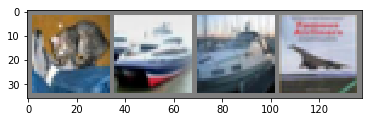

GroundTruth:    cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = images.to(device), labels.to(device)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

Predicted:    cat  ship truck plane


### 6.5.5 测试模型

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 74 %
Accuracy of  bird : 53 %
Accuracy of   cat : 49 %
Accuracy of  deer : 72 %
Accuracy of   dog : 54 %
Accuracy of  frog : 64 %
Accuracy of horse : 73 %
Accuracy of  ship : 83 %
Accuracy of truck : 82 %


### 6.5.6 采用全局平均池化

In [18]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 36, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.pool2 = nn.MaxPool2d(2, 2)
        #使用全局平均池化层
        self.aap=nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.aap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x

net = Net()
net=net.to(device)

In [19]:
print("net_gvp have {} paramerters in total".format(sum(x.numel() for x in net.parameters())))

net_gvp have 16022 paramerters in total


In [20]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.122
[1,  4000] loss: 1.868
[1,  6000] loss: 1.758
[1,  8000] loss: 1.683
[1, 10000] loss: 1.630
[1, 12000] loss: 1.570
[2,  2000] loss: 1.519
[2,  4000] loss: 1.491
[2,  6000] loss: 1.470
[2,  8000] loss: 1.446
[2, 10000] loss: 1.400
[2, 12000] loss: 1.387
[3,  2000] loss: 1.347
[3,  4000] loss: 1.341
[3,  6000] loss: 1.319
[3,  8000] loss: 1.300
[3, 10000] loss: 1.303
[3, 12000] loss: 1.268
[4,  2000] loss: 1.254
[4,  4000] loss: 1.239
[4,  6000] loss: 1.237
[4,  8000] loss: 1.226
[4, 10000] loss: 1.214
[4, 12000] loss: 1.194
[5,  2000] loss: 1.187
[5,  4000] loss: 1.168
[5,  6000] loss: 1.159
[5,  8000] loss: 1.147
[5, 10000] loss: 1.156
[5, 12000] loss: 1.157
[6,  2000] loss: 1.142
[6,  4000] loss: 1.111
[6,  6000] loss: 1.137
[6,  8000] loss: 1.106
[6, 10000] loss: 1.103
[6, 12000] loss: 1.095
[7,  2000] loss: 1.108
[7,  4000] loss: 1.059
[7,  6000] loss: 1.088
[7,  8000] loss: 1.065
[7, 10000] loss: 1.062
[7, 12000] loss: 1.072
[8,  2000] loss: 1.057
[8,  4000] 

### 6.5.7像keras一样显示各层参数

In [22]:
import collections
import torch

def paras_summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = collections.OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                if hasattr(module, 'bias'):
                    params +=  torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if not isinstance(module, nn.Sequential) and \
               not isinstance(module, nn.ModuleList) and \
               not (module == model):
                hooks.append(module.register_forward_hook(hook))
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [torch.rand(1,*in_size) for in_size in input_size]
        else:
            x = torch.rand(1,*input_size)

        # create properties
        summary = collections.OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        return summary

In [23]:
net = CNNNet()
input_size=[3,32,32]
paras_summary(input_size,net)

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 28, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(1216))])),
             ('MaxPool2d-2',
              OrderedDict([('input_shape', [-1, 16, 28, 28]),
                           ('output_shape', [-1, 16, 14, 14]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 14, 14]),
                           ('output_shape', [-1, 36, 12, 12]),
                           ('trainable', True),
                           ('nb_params', tensor(5220))])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 36, 12, 12]),
                           ('output_shape', [-1, 36, 6, 6]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict([('input_shape', [-1, 1296]),
 